# Jonathan Halverson
# Thursday, November 30, 2017
# Transfer learning with a CNN: Part 2

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Create a train-test split. We work with the indices until the actual image data is needed:

In [2]:
daisies = glob.glob('datasets/flower_photos/junk1/*.png')
roses = glob.glob('datasets/flower_photos/junk2/*.png')
sunflrs = glob.glob('datasets/flower_photos/junk3/*.png')
paths = daisies + roses + sunflrs
labels = np.concatenate((np.zeros(len(daisies), dtype=np.int32),
                         np.ones(len(roses), dtype=np.int32),
                         2 * np.ones(len(sunflrs), dtype=np.int32)))
assert len(paths) == labels.size, "Size mismatch"

In [3]:
thres = int(0.8 * labels.size)
indices = np.random.permutation(range(labels.size))
train_indices = indices[:thres]
test_indices = indices[thres:]

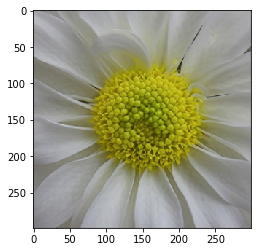

In [4]:
img = mpimg.imread(daisies[0])
plt.imshow(img)

The function below returns a batch of samples and their labels. Note that the RGB values are scaled between -1 and 1 which is the correct choice for the Inception model.

In [5]:
# Geron appears to fail to shift values between -1 and 1
# we throw away the fourth channel (transparency)
def prepare_batch(t_indices, batch_size):
     indices = np.random.choice(t_indices, size=batch_size, replace=False)
     X_paths = [paths[idx] for idx in indices]
     images = [2.0 * mpimg.imread(X_path)[:,:,:3] - 1.0 for X_path in X_paths]
     return np.stack(images), labels[indices]

### Reload the model (it has already been downloaded)

In [6]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

In [7]:
tf.reset_default_graph()

In [8]:
X = tf.placeholder(dtype=tf.float32, shape=[None, 299, 299, 3], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
     logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)

inception_saver = tf.train.Saver()

Next we go looking for the top layers we need to retrain:

In [9]:
for op in tf.get_default_graph().get_operations():
     print (op.name)

X
PlaceholderWithDefault/input
PlaceholderWithDefault
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/shape
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/mean
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/stddev
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/TruncatedNormal
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/mul
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal
InceptionV3/Conv2d_1a_3x3/weights
InceptionV3/Conv2d_1a_3x3/weights/Assign
InceptionV3/Conv2d_1a_3x3/weights/read
InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer/scale
InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer/L2Loss
InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution/Shape
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution/dilation_rate
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution
InceptionV3/Conv2d_1a_3x3/BatchNorm/beta/Initializer/

In [10]:
[v.name for v in tf.trainable_variables()]

[u'InceptionV3/Conv2d_1a_3x3/weights:0',
 u'InceptionV3/Conv2d_1a_3x3/BatchNorm/beta:0',
 u'InceptionV3/Conv2d_2a_3x3/weights:0',
 u'InceptionV3/Conv2d_2a_3x3/BatchNorm/beta:0',
 u'InceptionV3/Conv2d_2b_3x3/weights:0',
 u'InceptionV3/Conv2d_2b_3x3/BatchNorm/beta:0',
 u'InceptionV3/Conv2d_3b_1x1/weights:0',
 u'InceptionV3/Conv2d_3b_1x1/BatchNorm/beta:0',
 u'InceptionV3/Conv2d_4a_3x3/weights:0',
 u'InceptionV3/Conv2d_4a_3x3/BatchNorm/beta:0',
 u'InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/weights:0',
 u'InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0',
 u'InceptionV3/Mixed_5b/Branch_1/Conv2d_0a_1x1/weights:0',
 u'InceptionV3/Mixed_5b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0',
 u'InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights:0',
 u'InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/beta:0',
 u'InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/weights:0',
 u'InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0',
 u'InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/weights:

In [11]:
logits.op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/BiasAdd:0' shape=(?, 1, 1, 1001) dtype=float32>

In [12]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Conv2d_1c_1x1/convolution:0' shape=(?, 1, 1, 1001) dtype=float32>

In [13]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/Identity:0' shape=(?, 1, 1, 2048) dtype=float32>

Aha! There we are, this is the output of the dropout layer. This is the very last layer before the output layer in the Inception v3 network.

In [14]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

In [15]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/Identity:0' shape=(?, 1, 1, 2048) dtype=float32>

We can drop the 2nd and 3rd dimensions using the tf.squeeze() function:

In [16]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

In [17]:
n_outputs = np.unique(labels).size

with tf.name_scope("new_output_layer"):
     flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
     Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

Since we want to train only the output layer (all other layers must be frozen), we must pass the list of variables to train to the optimizer's minimize() method:

In [18]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
     xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
     loss = tf.reduce_mean(xentropy)
     optimizer = tf.train.MomentumOptimizer(learning_rate=0.001, momentum=0.9, use_nesterov=True)
     flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
     training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("eval"):
     correct = tf.nn.in_top_k(flower_logits, y, 1)
     accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
     init = tf.global_variables_initializer()
     saver = tf.train.Saver()

Let's take a look at the trainable variables:

In [19]:
[v.name for v in flower_vars]

[u'flower_logits/kernel:0', u'flower_logits/bias:0']

In [20]:
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

In [21]:
n_epochs = 5
batch_size = 50
n_iterations_per_epoch = train_indices.size // batch_size

with tf.Session() as sess:
     init.run()
     inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

     for epoch in range(n_epochs):
          print "Epoch", epoch
          for iteration in range(n_iterations_per_epoch):
               X_batch, y_batch = prepare_batch(train_indices, batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch, training: True})
          acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
          print "  Train accuracy:", acc_train

     X_test, y_test = prepare_batch(test_indices, test_indices.size)
     acc_test = accuracy.eval(feed_dict={X:X_test, y:y_test})
     print "Test accuracy:", acc_test

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0
  Train accuracy: 0.82
Epoch 1
  Train accuracy: 0.86
Epoch 2
  Train accuracy: 0.9
Epoch 3
  Train accuracy: 1.0
Epoch 4
  Train accuracy: 0.92
Test accuracy: 0.916456
